In [81]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap

In [2]:
path = '/Users/jiachenyao/Desktop/Thesis/OpenFace_data/All_data_intensity_2/'

In [3]:
# Load data and extract features
dfs = []
num_deleted = 0

max_rows = 0
max_file = None

for filename in os.listdir(path):
    if filename.endswith(".csv"):
        filepath = os.path.join(path, filename)
        df = pd.read_csv(filepath)
        


        # Check the ratio of rows with confidence >= 0.98 to the total number of rows
        if len(df)>320 or len(df[df["confidence"]<0.98])/len(df) >= 0.15:
            # print the filename and delete the df variable
            #print(filename)
            del df
            num_deleted += 1
        else:
            # Select confidence >= 0.98 & success = 1
            df = df.loc[(df["confidence"]>= 0.98) & (df["success"]== 1 ) ] 
            # Drop columns that does not contain facial feature information
            df = df.drop(columns=["confidence","success","frame", "face_id", "timestamp"])
            
            # Drop binary AU features
            cols_to_drop = df.filter(regex='AU.*_c').columns
            df = df.drop(columns=cols_to_drop)

            # Feature selection
            # 115 features, excluding 3D and eye
            #df = df.iloc[:, np.concatenate([range(0, 8), range(288,294),range(299,306),range(311,321),range(325,330),
                                            #range(342,362),range(367,374),range(379,389),range(393,398),
                                            #range(410,430),range(674,691)])]

            
            # only mouth
            df = df.iloc[:, np.concatenate([range(342,362), range(410,430),range(478,498),range(546,566),range(614,634)
                                            ])]
            

            df = df.fillna(method='ffill') # Forward fill missing values
            df = df.fillna(method='bfill') # Backward fill missing values

            # Add a column to indicate the emotion
            df.insert(0, 'emotion', os.path.splitext(os.path.basename(filepath))[0])
            # Exclude actor id
            df['emotion'] = df['emotion'].str.split('_', n=1, expand=True)[1]
            
            
            num_rows = df.shape[0]
            if num_rows > max_rows:
                max_rows = num_rows
                max_file = filename
            
            dfs.append(df)
        
print(f"{num_deleted} dataframes were deleted.")
print(len(dfs))

# Print file with maximum number of rows
print("File with maximum rows:", max_file)
print("Number of rows:", max_rows)


266 dataframes were deleted.
905
File with maximum rows: A205_mix_disg_sad_3070.csv
Number of rows: 299


In [4]:
columns = dfs[1].columns.tolist()
columns

['emotion',
 'x_48',
 'x_49',
 'x_50',
 'x_51',
 'x_52',
 'x_53',
 'x_54',
 'x_55',
 'x_56',
 'x_57',
 'x_58',
 'x_59',
 'x_60',
 'x_61',
 'x_62',
 'x_63',
 'x_64',
 'x_65',
 'x_66',
 'x_67',
 'y_48',
 'y_49',
 'y_50',
 'y_51',
 'y_52',
 'y_53',
 'y_54',
 'y_55',
 'y_56',
 'y_57',
 'y_58',
 'y_59',
 'y_60',
 'y_61',
 'y_62',
 'y_63',
 'y_64',
 'y_65',
 'y_66',
 'y_67',
 'X_48',
 'X_49',
 'X_50',
 'X_51',
 'X_52',
 'X_53',
 'X_54',
 'X_55',
 'X_56',
 'X_57',
 'X_58',
 'X_59',
 'X_60',
 'X_61',
 'X_62',
 'X_63',
 'X_64',
 'X_65',
 'X_66',
 'X_67',
 'Y_48',
 'Y_49',
 'Y_50',
 'Y_51',
 'Y_52',
 'Y_53',
 'Y_54',
 'Y_55',
 'Y_56',
 'Y_57',
 'Y_58',
 'Y_59',
 'Y_60',
 'Y_61',
 'Y_62',
 'Y_63',
 'Y_64',
 'Y_65',
 'Y_66',
 'Y_67',
 'Z_48',
 'Z_49',
 'Z_50',
 'Z_51',
 'Z_52',
 'Z_53',
 'Z_54',
 'Z_55',
 'Z_56',
 'Z_57',
 'Z_58',
 'Z_59',
 'Z_60',
 'Z_61',
 'Z_62',
 'Z_63',
 'Z_64',
 'Z_65',
 'Z_66',
 'Z_67']

In [5]:
dfs[1]

,emotion,x_48,x_49,x_50,x_51,x_52,x_53,x_54,x_55,x_56,...,Z_58,Z_59,Z_60,Z_61,Z_62,Z_63,Z_64,Z_65,Z_66,Z_67
0,mix_ang_fea_3070,913.1,927.9,946.0,962.4,981.3,1005.6,1029.1,1012.0,991.7,...,546.3,551.1,560.0,547.5,545.2,545.0,554.4,545.1,545.4,547.9
1,mix_ang_fea_3070,911.7,926.3,944.5,961.4,981.0,1005.1,1028.5,1011.5,991.4,...,545.7,550.5,559.4,546.7,544.3,544.3,553.6,544.7,544.9,547.3
2,mix_ang_fea_3070,911.2,926.0,944.3,961.1,980.6,1004.8,1028.4,1011.1,990.9,...,546.1,551.1,559.9,547.2,544.7,544.6,553.8,544.9,545.1,547.7
3,mix_ang_fea_3070,910.8,925.9,944.3,960.9,980.3,1004.6,1028.2,1011.0,990.6,...,549.2,554.3,562.9,550.2,547.8,547.6,556.8,547.9,548.2,550.8
4,mix_ang_fea_3070,910.9,926.0,944.3,960.9,980.3,1004.5,1028.0,1010.8,990.6,...,549.0,553.9,562.5,550.1,547.7,547.5,556.6,547.7,547.9,550.5
5,mix_ang_fea_3070,911.6,926.0,944.3,960.8,979.9,1004.4,1028.5,1010.7,990.2,...,545.5,550.5,559.7,546.9,544.6,544.5,553.4,544.6,544.6,547.1
6,mix_ang_fea_3070,912.8,928.1,946.5,962.5,981.0,1004.5,1027.9,1010.7,991.1,...,546.4,551.1,560.1,547.6,545.4,545.6,555.1,545.7,545.6,547.9
7,mix_ang_fea_3070,914.1,929.3,948.0,963.4,981.2,1005.0,1029.0,1011.7,991.9,...,539.8,544.8,554.9,541.5,539.5,539.7,550.2,539.6,539.4,541.6
8,mix_ang_fea_3070,915.8,930.3,949.3,963.6,979.9,1004.5,1029.8,1011.5,990.8,...,533.0,538.3,548.8,534.6,532.7,532.9,543.4,533.2,532.9,534.9
9,mix_ang_fea_3070,930.2,936.8,950.5,963.5,978.0,997.1,1014.6,1004.0,990.3,...,525.9,526.5,532.3,525.5,523.8,524.3,529.7,526.0,525.8,527.3


(array([ 4.,  7., 21., 33., 40., 44., 37., 35., 38., 38., 31., 29., 41.,
        50., 55., 41., 41., 34., 40., 40., 34., 29., 32., 36., 27., 20.,
        14., 10.,  4.,  0.,  0.,  1.,  1.,  2.,  0.,  1.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 33. ,  42.3,  51.6,  60.9,  70.2,  79.5,  88.8,  98.1, 107.4,
        116.7, 126. , 135.3, 144.6, 153.9, 163.2, 172.5, 181.8, 191.1,
        200.4, 209.7, 219. , 228.3, 237.6, 246.9, 256.2, 265.5, 274.8,
        284.1, 293.4, 302.7, 312. , 321.3, 330.6, 339.9, 349.2, 358.5,
        367.8, 377.1, 386.4, 395.7, 405. , 414.3, 423.6, 432.9, 442.2,
        451.5, 460.8, 470.1, 479.4, 488.7, 498. , 507.3, 516.6, 525.9,
        

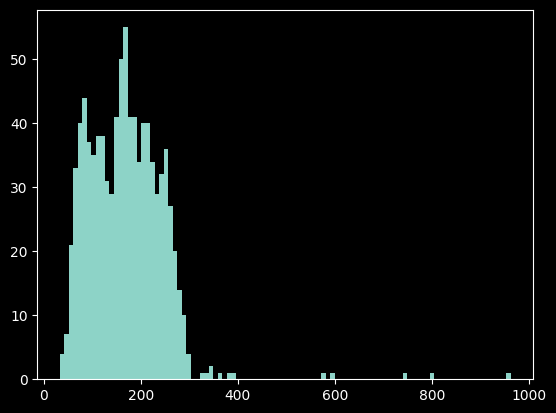

In [34]:
dfs_len = [len(df) for df in dfs]

plt.hist(dfs_len, bins=100)

In [6]:
# Normalize the data
for df in dfs:
    cols_to_normalize = df.columns.difference(['emotion'])
    #df[cols_to_normalize] = df[cols_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min())) # mix-max normalization
    df[cols_to_normalize] = df[cols_to_normalize].apply(lambda x: (x - x.mean()) / x.std()) # Z normalization

In [ ]:
dfs[1]

In [7]:
# change emotion name
emotions = []

for df in dfs:
    emotion = df['emotion'].unique()
    emotion = emotion[0]
    if emotion.startswith('mix'):
        emotion = emotion.rsplit("_", 1)[0]
    else:
        emotion = emotion.split("_", 1)[0]
    df['emotion'] = emotion
    emotions.append(emotion)

In [8]:
# encode labels
label_encoder = LabelEncoder()
label_list = label_encoder.fit_transform(emotions)
label_mapping = dict(zip(label_list, emotions))

emo_labels = []
for df in dfs:
    emotion = df['emotion'].iloc[0]
    label = label_encoder.transform([emotion])[0]
    emo_labels.extend([label] * len(df))

In [9]:
num_features = 100
num_files = len(dfs)

# Combine dataframes into a single tensor
data = torch.zeros((num_files, max_rows, num_features))  # 1e-6 is added to avoid log(0)
labels = torch.zeros((num_files, max_rows), dtype=torch.long) - 1 # -1 indicates missing values
for i, df in enumerate(dfs):
    encoded_labels = label_list[i]  # Convert non-numeric labels to numeric labels
    data[i, : df.shape[0]] = torch.tensor(df.iloc[:,1:101].values, dtype=torch.float32)  # Exclude the first column (labels)
    labels[i, : df.shape[0]] = torch.tensor(encoded_labels, dtype=torch.long)  # Use the encoded labels

In [10]:
labels.shape

torch.Size([905, 299])

In [11]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

In [12]:
# Create custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [13]:
# load dataset
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

# load dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [14]:
class TimeDistributed(nn.Module):
    def __init__(self, module: nn.Module, batch_first: bool = True):
        super().__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)
        return y

In [15]:
class TimeVAE_base(nn.Module):
    def __init__(self, latent_dim):
        super(TimeVAE_base, self).__init__()
        # encoder layers
        self.encoder_convs = nn.Sequential(
            nn.Conv1d(299, 128, 3, stride=2, padding=1,bias=False),
            nn.ReLU(True),
            nn.Conv1d(128, 64, 3, stride=2, padding=1, bias=False),
            nn.ReLU(True),
        
        ) # output shape: (batch_size, 64, 45)
        self.fc1 = nn.Linear(25, 16)
        self.mean = nn.Linear(16, latent_dim)
        self.var = nn.Linear(16, latent_dim)

        # decoder layers
        self.fc2 = nn.Linear(latent_dim, 16)
        self.fc3 = nn.Linear(16, 25)
        self.decoder_convs = nn.Sequential(
            nn.ConvTranspose1d(64, 128, 3, stride=2, padding=1,output_padding=1, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose1d(128, 299, 3, stride=2, padding=1,output_padding=1 ,bias=False),
            nn.ReLU(True)
        ) # output shape: (batch_size, 963, 288)

        self.time_distributed = TimeDistributed(nn.Linear(100, 100))
        
    def encode(self, x):
        x = self.encoder_convs(x)
        x = x.contiguous().view(-1, x.size(-1)) # flatten
        x = self.fc1(x)
        mean = self.mean(x)
        log_var = self.var(x)
        return mean, log_var
    
    def reparaterize(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mean + eps*std
    
    def decode(self, z):
        z = self.fc2(z)
        z = self.fc3(z)
        z = z.contiguous().view(-1, 64, 25) # reshape
        z = self.decoder_convs(z)
        z = self.time_distributed(z)
        return z
    
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparaterize(mean, log_var)
        return self.decode(z), mean, log_var

In [36]:
# VAE loss function
def vae_loss(x, x_recon, mean, log_var, beta=1):
    recon_loss = nn.MSELoss()(x_recon, x)
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return recon_loss + kl_loss * beta

In [58]:
# Initialize the VAE model, optimizer, and other settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_dim = 2
model = TimeVAE_base(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 50

In [59]:
def train_test_vae(epochs, train_loader, val_loader, model, optimizer):
    loss_history = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_data, _ in tqdm(train_loader):
            batch_data = batch_data.to(device)
            optimizer.zero_grad()
            x_recon, mean, log_var = model(batch_data)
            loss = vae_loss(batch_data, x_recon, mean, log_var, beta=2) # beta_VAE
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            loss_history.append(loss.item())
        train_loss /= len(train_loader.dataset)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_data, _ in val_loader:
                batch_data = batch_data.to(device)
                x_recon, mean, log_var = model(batch_data)
                loss = vae_loss(batch_data, x_recon, mean, log_var, beta=2) # beta_VAE
                val_loss += loss.item()
            
        val_loss /= len(val_loader.dataset)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}')

    # plot the training loss curve
    plt.plot(loss_history)
    plt.xlabel('Iterations')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Curve')
    plt.xlim((2,50)) 
    plt.show()


100%|██████████| 23/23 [00:01<00:00, 22.25it/s]


Epoch 1, Train Loss: 5.9586
Epoch 1, Val Loss: 1.3868


100%|██████████| 23/23 [00:01<00:00, 21.84it/s]


Epoch 2, Train Loss: 0.7175
Epoch 2, Val Loss: 0.3850


100%|██████████| 23/23 [00:00<00:00, 23.81it/s]


Epoch 3, Train Loss: 0.2783
Epoch 3, Val Loss: 0.2184


100%|██████████| 23/23 [00:01<00:00, 22.28it/s]


Epoch 4, Train Loss: 0.1411
Epoch 4, Val Loss: 0.1342


100%|██████████| 23/23 [00:00<00:00, 23.56it/s]


Epoch 5, Train Loss: 0.1166
Epoch 5, Val Loss: 0.1641


100%|██████████| 23/23 [00:00<00:00, 23.41it/s]


Epoch 6, Train Loss: 0.1082
Epoch 6, Val Loss: 0.1248


100%|██████████| 23/23 [00:00<00:00, 23.17it/s]


Epoch 7, Train Loss: 0.0807
Epoch 7, Val Loss: 0.1047


100%|██████████| 23/23 [00:01<00:00, 22.95it/s]


Epoch 8, Train Loss: 0.0675
Epoch 8, Val Loss: 0.1034


100%|██████████| 23/23 [00:00<00:00, 23.09it/s]


Epoch 9, Train Loss: 0.0633
Epoch 9, Val Loss: 0.0867


100%|██████████| 23/23 [00:00<00:00, 23.53it/s]


Epoch 10, Train Loss: 0.0619
Epoch 10, Val Loss: 0.0831


100%|██████████| 23/23 [00:01<00:00, 22.44it/s]


Epoch 11, Train Loss: 0.0582
Epoch 11, Val Loss: 0.0960


100%|██████████| 23/23 [00:00<00:00, 23.25it/s]


Epoch 12, Train Loss: 0.0612
Epoch 12, Val Loss: 0.0999


100%|██████████| 23/23 [00:01<00:00, 21.51it/s]


Epoch 13, Train Loss: 0.0595
Epoch 13, Val Loss: 0.0881


100%|██████████| 23/23 [00:00<00:00, 23.47it/s]


Epoch 14, Train Loss: 0.0559
Epoch 14, Val Loss: 0.0812


100%|██████████| 23/23 [00:00<00:00, 23.61it/s]


Epoch 15, Train Loss: 0.0502
Epoch 15, Val Loss: 0.0763


100%|██████████| 23/23 [00:00<00:00, 23.25it/s]


Epoch 16, Train Loss: 0.0430
Epoch 16, Val Loss: 0.0713


100%|██████████| 23/23 [00:00<00:00, 23.69it/s]


Epoch 17, Train Loss: 0.0402
Epoch 17, Val Loss: 0.0725


100%|██████████| 23/23 [00:01<00:00, 22.60it/s]


Epoch 18, Train Loss: 0.0367
Epoch 18, Val Loss: 0.0639


100%|██████████| 23/23 [00:00<00:00, 23.54it/s]


Epoch 19, Train Loss: 0.0360
Epoch 19, Val Loss: 0.0700


100%|██████████| 23/23 [00:00<00:00, 23.55it/s]


Epoch 20, Train Loss: 0.0359
Epoch 20, Val Loss: 0.0667


100%|██████████| 23/23 [00:00<00:00, 23.79it/s]


Epoch 21, Train Loss: 0.0355
Epoch 21, Val Loss: 0.0631


100%|██████████| 23/23 [00:00<00:00, 23.46it/s]


Epoch 22, Train Loss: 0.0342
Epoch 22, Val Loss: 0.0646


100%|██████████| 23/23 [00:00<00:00, 23.65it/s]


Epoch 23, Train Loss: 0.0335
Epoch 23, Val Loss: 0.0636


100%|██████████| 23/23 [00:00<00:00, 23.64it/s]


Epoch 24, Train Loss: 0.0329
Epoch 24, Val Loss: 0.0645


100%|██████████| 23/23 [00:01<00:00, 22.70it/s]


Epoch 25, Train Loss: 0.0339
Epoch 25, Val Loss: 0.0696


100%|██████████| 23/23 [00:00<00:00, 23.41it/s]


Epoch 26, Train Loss: 0.0346
Epoch 26, Val Loss: 0.0610


100%|██████████| 23/23 [00:00<00:00, 23.54it/s]


Epoch 27, Train Loss: 0.0330
Epoch 27, Val Loss: 0.0635


100%|██████████| 23/23 [00:00<00:00, 23.34it/s]


Epoch 28, Train Loss: 0.0313
Epoch 28, Val Loss: 0.0565


100%|██████████| 23/23 [00:00<00:00, 23.25it/s]


Epoch 29, Train Loss: 0.0305
Epoch 29, Val Loss: 0.0595


100%|██████████| 23/23 [00:00<00:00, 23.42it/s]


Epoch 30, Train Loss: 0.0287
Epoch 30, Val Loss: 0.0533


100%|██████████| 23/23 [00:01<00:00, 21.10it/s]


Epoch 31, Train Loss: 0.0268
Epoch 31, Val Loss: 0.0548


100%|██████████| 23/23 [00:00<00:00, 23.13it/s]


Epoch 32, Train Loss: 0.0268
Epoch 32, Val Loss: 0.0534


100%|██████████| 23/23 [00:01<00:00, 22.67it/s]


Epoch 33, Train Loss: 0.0263
Epoch 33, Val Loss: 0.0551


100%|██████████| 23/23 [00:00<00:00, 23.27it/s]


Epoch 34, Train Loss: 0.0284
Epoch 34, Val Loss: 0.0514


100%|██████████| 23/23 [00:00<00:00, 23.54it/s]


Epoch 35, Train Loss: 0.0269
Epoch 35, Val Loss: 0.0549


100%|██████████| 23/23 [00:00<00:00, 23.43it/s]


Epoch 36, Train Loss: 0.0257
Epoch 36, Val Loss: 0.0492


100%|██████████| 23/23 [00:01<00:00, 22.91it/s]


Epoch 37, Train Loss: 0.0261
Epoch 37, Val Loss: 0.0542


100%|██████████| 23/23 [00:00<00:00, 23.37it/s]


Epoch 38, Train Loss: 0.0271
Epoch 38, Val Loss: 0.0505


100%|██████████| 23/23 [00:00<00:00, 23.20it/s]


Epoch 39, Train Loss: 0.0254
Epoch 39, Val Loss: 0.0496


100%|██████████| 23/23 [00:00<00:00, 23.32it/s]


Epoch 40, Train Loss: 0.0241
Epoch 40, Val Loss: 0.0463


100%|██████████| 23/23 [00:00<00:00, 23.23it/s]


Epoch 41, Train Loss: 0.0234
Epoch 41, Val Loss: 0.0486


100%|██████████| 23/23 [00:00<00:00, 23.82it/s]


Epoch 42, Train Loss: 0.0233
Epoch 42, Val Loss: 0.0436


100%|██████████| 23/23 [00:00<00:00, 23.03it/s]


Epoch 43, Train Loss: 0.0232
Epoch 43, Val Loss: 0.0474


100%|██████████| 23/23 [00:01<00:00, 21.70it/s]


Epoch 44, Train Loss: 0.0222
Epoch 44, Val Loss: 0.0419


100%|██████████| 23/23 [00:00<00:00, 23.12it/s]


Epoch 45, Train Loss: 0.0219
Epoch 45, Val Loss: 0.0450


100%|██████████| 23/23 [00:00<00:00, 23.58it/s]


Epoch 46, Train Loss: 0.0220
Epoch 46, Val Loss: 0.0432


100%|██████████| 23/23 [00:00<00:00, 23.16it/s]


Epoch 47, Train Loss: 0.0218
Epoch 47, Val Loss: 0.0443


100%|██████████| 23/23 [00:01<00:00, 21.87it/s]


Epoch 48, Train Loss: 0.0218
Epoch 48, Val Loss: 0.0419


100%|██████████| 23/23 [00:00<00:00, 23.51it/s]


Epoch 49, Train Loss: 0.0217
Epoch 49, Val Loss: 0.0441


100%|██████████| 23/23 [00:00<00:00, 23.45it/s]


Epoch 50, Train Loss: 0.0214
Epoch 50, Val Loss: 0.0430


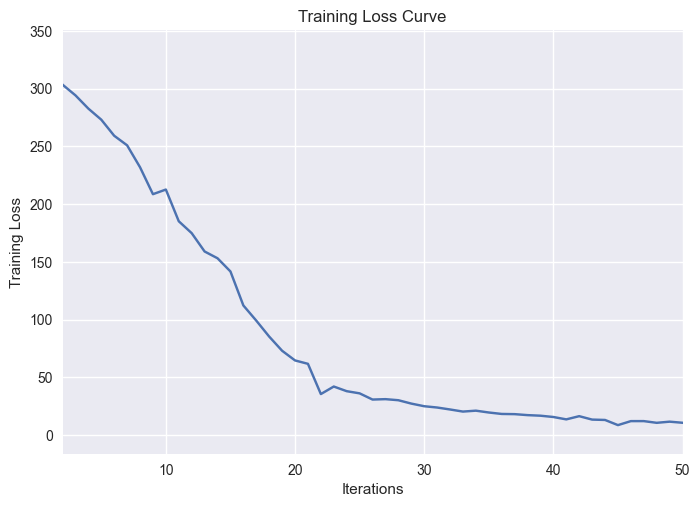

In [60]:
train_test_vae(epochs, train_loader, val_loader, model, optimizer)

In [61]:
def extract_latent_space(vae, data_loader):
    latent_space = []
    labels = []

    vae.eval()
    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            batch_data = batch_data.to(device)
            mean, log_var = vae.encode(batch_data)
            z = vae.reparaterize(mean, log_var)
            latent_space.append(z.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return np.vstack(latent_space), labels

In [70]:
# Extract latent space from the validation dataset
latent_space, labels = extract_latent_space(model, val_loader)


# Check dimensions
print("Shape of latent_space:", latent_space.shape)
print("Shape of labels:", len(labels))
print("Unique labels:", np.unique(labels))


Shape of latent_space: (11584, 2)
Shape of labels: 181
Unique labels: [-1  1  3  4  5  6  7  8  9 10 11 12 13 14]


In [71]:
latent_space = latent_space.reshape(181, 64, 2)
latent_space = np.sum(latent_space, axis=1)

In [72]:
for i in range(len(labels)):
    labels[i] = labels[i][0]


In [63]:
for i in range(len(labels)):
    labels[i] = np.full(64, labels[i][0])

labels = np.concatenate(labels)
labels = labels.reshape(-1)


In [53]:
# Use t-SNE to reduce the 10D latent space into a 2D space
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_space)



In [88]:
np.unique(labels)

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [108]:
# Plot latent space
colors_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
               'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan',] * 2

cmap = ListedColormap(colors_list)

#plt.style.use('seaborn-v0_8-muted')
plt.figure(figsize=(10, 7))
for idx,label in enumerate(np.unique(labels)):
    plt.scatter(latent_space[labels==label, 0], latent_space[labels==label, 1], label=label_mapping[label],c=cmap(idx))
plt.legend()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Clustering')
plt.show()

ValueError: Invalid RGBA argument: 'tab:black'

<Figure size 1000x700 with 0 Axes>

In [96]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [39]:
num_train_points = len(train_loader.dataset) * train_loader.batch_size
num_val_points = len(val_loader.dataset) * val_loader.batch_size
total_num_points = num_train_points + num_val_points

print(f"Number of data points: {total_num_points}")
print(f"Length of labels array: {len(labels)}")

Number of data points: 29344
Length of labels array: 917


ValueError: 'c' argument has 153819 elements, which is inconsistent with 'x' and 'y' with size 117376.

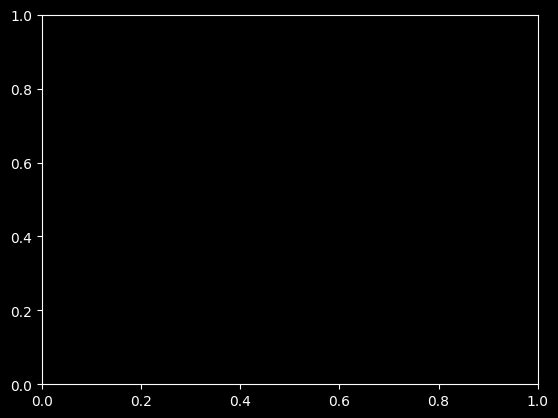

In [42]:
# Plot the clustering results
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels, cmap='viridis')
plt.colorbar()
plt.show()